<a href="https://colab.research.google.com/github/rosafilgueira/Seminar_MUIA/blob/main/Colab/lab_exercises/Volcanic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preparing the enviroment

In [ ]:
!git clone https://github.com/rosafilgueira/Seminar_MUIA.git
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Learning_Spark") \
    .getOrCreate()
sc = spark.sparkContext

data_path="/content/Seminar_MUIA/lab_exercises/Volcano_Analysis/"


## This notebook is for analysing VAAs - Volcanic Ash Advisories reports## 

Information   issued by a   Volcanic   Ash   Advisory   Center (VAAC)  concerning  the occurrence or expected  occurrence of volcanic  ash  that  may  affect the safety of aircraft operations. A VAA is a text message that identifies the volcano, time of eruption, observed position of the ash cloud, and the forecasted position of the ash. The
VAA is not to be used as a warning message. 

In the file *vaac_total_line.json* we can find information from many VAAs emited by different VAACs ( one entry by report).  We are going to a _DataFame_ to load the data and get the schema.

And we can explore/analyse different properties of the dataset:
    * Visualize/analyze the colours_code (warning level) by selecting a particular volcano.   
    * Number of reports for a particular volcano
    * Plot the flight level of the ashes observed and erupted (e.g. fl_obs_cld_L1, fl_eruption_L1)

In [ ]:
vaacDF = spark.read.json(data_path+'vaac_total_line.json')
vaacDF.cache()

DataFrame[colour_code: string, confirmed: bigint, file_name: string, fl_eruption_L1: string, fl_eruption_L2: string, fl_fcst_12hr_L1: string, fl_fcst_12hr_L2: string, fl_fcst_18hr_L1: string, fl_fcst_18hr_L2: string, fl_fcst_6hr_L1: string, fl_fcst_6hr_L2: string, fl_obs_cld_L1: string, fl_obs_cld_L2: string, id: string, info_source: string, issued_date: string, issued_time: string, name: string, no_id_satelite: bigint, nxt_date: string, nxt_time: string, referal: bigint, report_id: string, v_id: string, vaac_obs: string]

In [ ]:
vaacDF.printSchema()

root
 |-- colour_code: string (nullable = true)
 |-- confirmed: long (nullable = true)
 |-- file_name: string (nullable = true)
 |-- fl_eruption_L1: string (nullable = true)
 |-- fl_eruption_L2: string (nullable = true)
 |-- fl_fcst_12hr_L1: string (nullable = true)
 |-- fl_fcst_12hr_L2: string (nullable = true)
 |-- fl_fcst_18hr_L1: string (nullable = true)
 |-- fl_fcst_18hr_L2: string (nullable = true)
 |-- fl_fcst_6hr_L1: string (nullable = true)
 |-- fl_fcst_6hr_L2: string (nullable = true)
 |-- fl_obs_cld_L1: string (nullable = true)
 |-- fl_obs_cld_L2: string (nullable = true)
 |-- id: string (nullable = true)
 |-- info_source: string (nullable = true)
 |-- issued_date: string (nullable = true)
 |-- issued_time: string (nullable = true)
 |-- name: string (nullable = true)
 |-- no_id_satelite: long (nullable = true)
 |-- nxt_date: string (nullable = true)
 |-- nxt_time: string (nullable = true)
 |-- referal: long (nullable = true)
 |-- report_id: string (nullable = true)
 |-- v_id

Now we are going to create a new dataframe (df) by filtering out the rows which we dont have an issued date. And later from these rows, we are going to visualize the id of the volcano, colour and date values. 

In [ ]:
from pyspark.sql.functions import col, concat, to_timestamp
from pyspark.sql.types import TimestampType
df = (vaacDF 
        .where(col('issued_date').isNotNull())
        .select('v_id','name', 'colour_code', concat('issued_date', 'issued_time').alias('date'))
        .withColumn('date', to_timestamp('date', 'yyyyMMddHHmm').cast(TimestampType()).alias('date'))
     )
df.show()

+------+--------+-----------+-------------------+
|  v_id|    name|colour_code|               date|
+------+--------+-----------+-------------------+
|252010| LANGILA|       null|2004-12-17 04:08:00|
|252010| LANGILA|       null|2004-12-17 09:49:00|
|252010| LANGILA|       null|2004-12-17 16:17:00|
|252010| LANGILA|       null|2004-12-17 22:03:00|
|252010| LANGILA|       null|2004-12-17 22:18:00|
|252010| LANGILA|       null|2004-12-18 03:52:00|
|252010| LANGILA|       null|2004-12-18 09:52:00|
|252010| LANGILA|     orange|2005-05-03 02:43:00|
|252010| LANGILA|     orange|2005-05-03 22:07:00|
|252010| LANGILA|     orange|2005-05-04 22:11:00|
|252010| LANGILA|     orange|2005-05-05 03:58:00|
|252010| LANGILA|     orange|2005-05-05 07:07:00|
|252010| LANGILA|     orange|2005-05-05 12:47:00|
|252010| LANGILA|     orange|2005-05-05 18:44:00|
|252010| LANGILA|     orange|2005-05-06 01:02:00|
|252010| LANGILA|     orange|2005-05-06 06:38:00|
|252010| LANGILA|     orange|2005-05-06 12:59:00|


Next, we are going to create another dataframe (codedf) by replacing red, orange, yellow and green  by  "4","3","2","1" respectively. 

In [ ]:
from pyspark.sql.types import IntegerType
codedf = (df
              .where(col('colour_code').isNotNull())
              .replace(['red', 'orange', 'yellow', 'green'], ["4", "3", "2", "1"], 'colour_code')
              .withColumn('colour_code', col('colour_code').cast(IntegerType()))
         )
codedf.show()

+------+--------+-----------+-------------------+
|  v_id|    name|colour_code|               date|
+------+--------+-----------+-------------------+
|252010| LANGILA|          3|2005-05-03 02:43:00|
|252010| LANGILA|          3|2005-05-03 22:07:00|
|252010| LANGILA|          3|2005-05-04 22:11:00|
|252010| LANGILA|          3|2005-05-05 03:58:00|
|252010| LANGILA|          3|2005-05-05 07:07:00|
|252010| LANGILA|          3|2005-05-05 12:47:00|
|252010| LANGILA|          3|2005-05-05 18:44:00|
|252010| LANGILA|          3|2005-05-06 01:02:00|
|252010| LANGILA|          3|2005-05-06 06:38:00|
|252010| LANGILA|          3|2005-05-06 12:59:00|
|252010| LANGILA|          3|2005-05-06 18:52:00|
|252010| LANGILA|          3|2005-05-07 01:36:00|
|252010| LANGILA|          3|2005-05-07 06:31:00|
|252010| LANGILA|          3|2005-05-07 12:27:00|
|252010| LANGILA|          3|2005-05-07 18:22:00|
|252010| LANGILA|          3|2005-05-08 00:35:00|
|252010| LANGILA|          3|2005-06-08 09:48:00|


Now, we want to visualise all the different volcano ids (v_id) that we have in the codedf dataframe.

In [ ]:
ids = codedf.select('v_id').distinct().rdd.flatMap(lambda x: x).collect()
print(ids)

['0501-08', '0502-', '241040', '261080', '354006', '263350', '357080', '0502-14', '355100', '311240', '0501-07', '0607-04', '372020', '0505-01', '0502-09', '264150', '263280', '266030', '300260', '0606-13', '300270', '268060', '262000', '0203-03', '252140', '0501-02', '300250', '357150', '264030', '0502-07', '1256', '263250', '0501-03', '311160', '0603-22', '357091', '0502-11', '266100', '264050', '0502-08', '252010', '357090', '354020', '0608-06', '1507-12', '0607-01', '1101-36', '263340', '313030', '264100', '233020', '255020', '384010', '0601-23', '267020', '0601-16', '268010', '0603-14', '0601-14', '1102-07', '0604-16', '0603-09', '251020', '358020', '300230', '264270', '312170', '251030', '263180', '260010', '311130', '252120', '373010', '290240', '264180', '263170', '264260', '357120', '263310', 'xxxx', '263300', '261170', '31129', '268030', '0603-18', '268040']


We are going to create a pandas dataframe (data) from the codedf dataframe. In this dataframe we will store the v_ids which are equal 252010 (so we select a particular volcano), and we will store the date and colour_code information. 

In [ ]:
import pandas
data = codedf.where('v_id == "252010"').select('date', 'colour_code').toPandas()
print(data)

                   date  colour_code
0   2005-05-03 02:43:00            3
1   2005-05-03 22:07:00            3
2   2005-05-04 22:11:00            3
3   2005-05-05 03:58:00            3
4   2005-05-05 07:07:00            3
..                  ...          ...
274 2017-01-25 03:45:00            3
275 2017-01-25 09:30:00            3
276 2017-01-25 15:30:00            3
277 2017-01-25 21:30:00            3
278 2017-01-26 03:30:00            3

[279 rows x 2 columns]


Finally, we print the dataframe for visualzing the change of colours over the years. 

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
plt.style.use('classic')

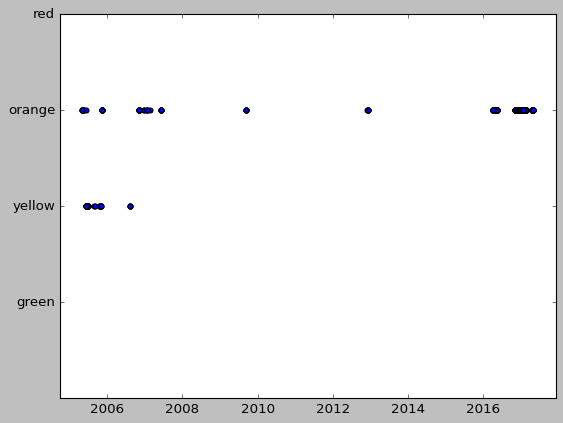

In [ ]:
plt.scatter(data['date'].tolist(), data['colour_code'].tolist())
plt.yticks(range(0,5), ('', 'green', 'yellow', 'orange', 'red') )

plt.show()

We can also analyse the frequency of reports of a particu

In [ ]:
frequency = vaacDF.filter('v_id == 283040').select('v_id','issued_date').groupBy('issued_date').count()
fd = frequency.toPandas()
fd

,issued_date,count
0,20141008,4
1,20140929,2
2,20141006,5
3,20141001,4
4,20141004,6
5,20141007,5
6,20141009,5
7,20141002,4
8,20141010,3
9,20140930,4


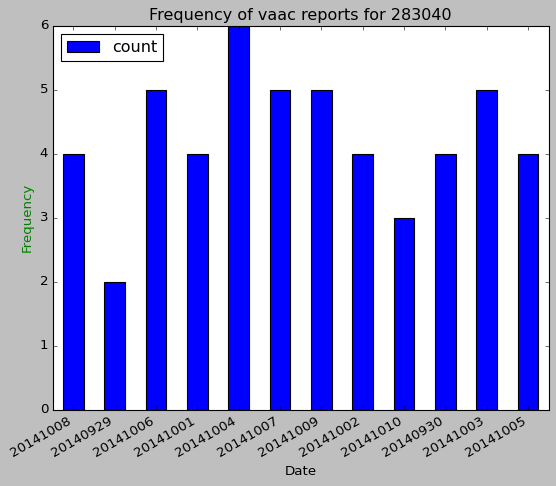

In [ ]:
ax = fd.plot.bar('issued_date', 'count')
ax.set_title('Frequency of vaac reports for 283040')
ax.legend(numpoints=1, loc='upper left')
ax.set_xlabel('Date')
ax.set_ylabel('Frequency', color='g')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()